In [1]:
# set seeds
import random
import numpy as np
import torch

def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

set_seed(42)

In [2]:

CONFIG = {
    # Training hyperparameters
    'learning_rate': 0.02,
    'batch_size': 320 * 60,
    'num_epochs': 10,
    'weight_decay': 0.0,

    # Data splits
    'train_split': 0.8,
    'random_seed': 42,

    # Model parameters
    'num_classes': 2,
    'd_mlp': 512
}

# Load NT model

We load the NT model whose activations we use to train the linear probe. Key variable: size of model

In [8]:
"loading smallest nucleotide transformer (50m params)"
from transformers import AutoTokenizer, AutoModelForMaskedLM, AutoConfig


num_params = 500 

# Import the tokenizer and the model
tokenizer_nt = AutoTokenizer.from_pretrained(f"InstaDeepAI/nucleotide-transformer-v2-{num_params}m-multi-species", trust_remote_code=True)
model_nt = AutoModelForMaskedLM.from_pretrained(f"InstaDeepAI/nucleotide-transformer-v2-{num_params}m-multi-species", trust_remote_code=True)


/home/maiwald/miniconda3/envs/prokka_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/maiwald/miniconda3/envs/prokka_env/lib/python3.12/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


# Load and preprocess addgene dataset

To get activations from the NT-model, we need to run it on sequences. Here we load and preprocess plasmid sequences from addgene.

In [ ]:
import sys
sys.path.append('../src')
import utils
import importlib
importlib.reload(utils)

# Constants
TEST_DATA_PATH = 'path/to/test_data.csv'
TRAIN_DATA_PATH = 'path/to/train_data.csv'

# Preprocess data: each data point has shape (DNA_seq: str, nation_idx: int)
df_train, df_val = utils.preprocess_data(TRAIN_DATA_PATH, TEST_DATA_PATH)

Load 3 dataframes of annotated plasmid sequences (1000 each). The annotations serve as training labels for probing

In [ ]:
# load token_df for >= 1000 seqs
folder_path = 'path/to/annotated_seqs/'

# load pkl files
token_df_1k_s0 = pd.read_pickle(folder_path + 'token_df_1k_ss0_standardized.pkl')
token_df_1k_s1 = pd.read_pickle(folder_path + 'token_df_1k_ss1_standardized.pkl')
token_df_1k_s2 = pd.read_pickle(folder_path + 'token_df_1k_ss2_standardized.pkl')

# Training linear probes

## Set up dataset

In [1]:
import sys
sys.path.append('../src')
import train_probes
importlib.reload(train_probes)

layer_N = 9 #@param
probe_inputs = train_probes.prepare_probe_inputs(
    test_data=df_val,
    model=model_nt,
    tokenizer=tokenizer_nt,
    token_df_path='path/to/annotated_seqs',
    layer_num=layer_N,
    subset_indices=(0,1,2),
    flatten = True)

xs = probe_inputs['activations']

sequence_level = False

if sequence_level:
  xs = xs.mean(dim=1)

ModuleNotFoundError: No module named 'sklearn'

In [ ]:
importlib.reload(train_probes)
from train_probes import process_annotation

dfs = pd.concat([probe_inputs['token_data']['dataframes']['s0'],
                 probe_inputs['token_data']['dataframes']['s1'],
                 probe_inputs['token_data']['dataframes']['s2']],
                ignore_index=True)

if sequence_level:

  ys = dfs.groupby('seq_id').apply(
    lambda x: 1 if x['token_annotations'].explode().str.contains('CMV enhancer').any() else 0
    )
  y_tensor = torch.tensor(ys.values)
  x_tensor = xs


else:

    target_value = ''
    result = process_annotation(
        df=dfs,
        xs=xs,
        annotation=["HIV", "env", "RRE"],
        target_value=target_value
    )

    x_tensor = result['features']
    y_tensor = result['labels']

    print(f"Baserate accuracy for {target_value}: {result['statistics']['base_rate_accuracy']:.4f}")

Using annotation-based labeling with annotations: ['HIV', 'env', 'RRE']
Found 20669 positive examples
Baserate accuracy for : 0.9865


# Measure F1-score for trained probe-weights

In [ ]:
# load probe weights
path = "path/to/META_saes"
dec_weights = torch.load(f"{path}/meta_sae_decoder_weights_D128_L0_6.pt", map_location=torch.device('cpu'))

## extract relevant rows
hiv_ID = 61 - 1 # starts at 0 whereas xcel started at 1
amr_ID = 126 - 1

dec_hiv_row = dec_weights[hiv_ID]
dec_amr_row = dec_weights[amr_ID]

In [ ]:
# randomly permute the y_tensor
y_tensor_perm = y_tensor[torch.randperm(y_tensor.size(0))]

In [ ]:
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score
from typing import Dict, Any
import torch

def measure_f1_with_split(
    weights: torch.Tensor,
    activations: torch.Tensor,
    labels: torch.Tensor,
    bias_range: tuple = (-5.0, 5.0),
    num_bias_points: int = 100,
    device: str = "cuda",
    split_ratio: float = 0.5
) -> Dict[str, Any]:
    """
    Split data into two halves:
      - one for bias optimization (training set),
      - one for evaluation (test set).
    Compute F1, precision, and recall across bias values on training,
    then evaluate best bias on test set.
    """
    # Move data to device
    weights = weights.to(device)
    activations = activations.to(device)
    labels = labels.to(device)

    # Shuffle indices for random split
    num_samples = activations.shape[0]
    indices = torch.randperm(num_samples)
    split_point = int(num_samples * split_ratio)
    train_idx, test_idx = indices[:split_point], indices[split_point:]

    X_train, y_train = activations[train_idx], labels[train_idx]
    X_test, y_test = activations[test_idx], labels[test_idx]

    bias_values = torch.linspace(bias_range[0], bias_range[1], num_bias_points)
    f1_scores_train = []
    precision_scores_train = []
    recall_scores_train = []

    # Sweep over bias values on the training set
    for bias in bias_values:
        logits = torch.matmul(X_train, weights.unsqueeze(-1)).squeeze() + bias
        preds = (torch.sigmoid(logits) > 0.5).cpu().numpy()
        y_true = y_train.cpu().numpy()

        f1 = f1_score(y_true, preds, zero_division=0)
        precision = precision_score(y_true, preds, zero_division=0)
        recall = recall_score(y_true, preds, zero_division=0)

        f1_scores_train.append(f1)
        precision_scores_train.append(precision)
        recall_scores_train.append(recall)

    # Pick the best bias based on train F1
    best_idx = int(np.argmax(f1_scores_train))
    best_bias = bias_values[best_idx].item()

    # Evaluate on test set using the best bias
    logits_test = torch.matmul(X_test, weights.unsqueeze(-1)).squeeze() + best_bias
    preds_test = (torch.sigmoid(logits_test) > 0.5).cpu().numpy()
    y_true_test = y_test.cpu().numpy()

    test_f1 = f1_score(y_true_test, preds_test, zero_division=0)
    test_precision = precision_score(y_true_test, preds_test, zero_division=0)
    test_recall = recall_score(y_true_test, preds_test, zero_division=0)

    return {
        "bias_values": bias_values.cpu().numpy(),
        "f1_scores_train": f1_scores_train,
        "precision_train": precision_scores_train,
        "recall_train": recall_scores_train,
        "best_bias": best_bias,
        "best_f1_train": f1_scores_train[best_idx],
        "test_f1": test_f1,
        "test_precision": test_precision,
        "test_recall": test_recall,
        "train_size": len(train_idx),
        "test_size": len(test_idx),
    }


In [ ]:
from itertools import chain, combinations


## specificy annotations to evaluate probe on

annotations = [["HIV"], ["env"], ["RRE"]]

# Get all non-empty subsets of annotations
annotation_powerset = list(
    chain.from_iterable(combinations(annotations, r) for r in range(1, len(annotations) + 1))
)
# Optional: flatten each combination
annotation_powerset = [sum(subset, []) for subset in annotation_powerset]

print(annotation_powerset)
# post-hoc append 'HIV-1 Ψ', 'HIV PBS', 'HIV-1 DIS', 'HIV-1 SD'
annotation_powerset.append(["HIV-1 Ψ"])
annotation_powerset.append(["HIV PBS"])
annotation_powerset.append(["HIV-1 DIS"])
annotation_powerset.append(["HIV-1 SD"])


# store test-performance (after threshold optimisation)
results_summary = []

sanity_check = True

# --- Improved printing loop ---
for annotation_list in annotation_powerset:
    print(f"\n\033[1;34m=== Evaluating annotation: {annotation_list} ===\033[0m")

    target_value = ''
    result = process_annotation(
        df=dfs,
        xs=xs,
        annotation=annotation_list,
        target_value=target_value
    )

    x_tensor = result['features']
    y_tensor = result['labels']

    # Sanity check: try random permutation
    if sanity_check:
        y_tensor= y_tensor[torch.randperm(y_tensor.size(0))]

    base_acc = result['statistics']['base_rate_accuracy']
    print(f"→ Base rate accuracy: \033[1;33m{base_acc:.4f}\033[0m")

    results_dict = measure_f1_with_split(
        weights=dec_hiv_row,
        activations=x_tensor,
        labels=y_tensor,
        bias_range=(-10, 25),
        num_bias_points=50,
        device="cuda"
    )

    print(f"\n\033[1;32m--- Results Summary ---\033[0m")

    print(f"\n\033[1;35mF1 / Precision / Recall (first 5 bias points):\033[0m")
    print(
          f"F1={results_dict['test_f1']:.4f} / "
          f"P={results_dict['test_precision']:.4f} / "
          f"R={results_dict['test_recall']:.4f}")

    results_summary.append({
        "annotation": " + ".join(annotation_list),
        "test_f1": results_dict["test_f1"],
        "test_precision": results_dict["test_precision"],
        "test_recall": results_dict["test_recall"],
    })


In [ ]:
# Save results to data directory
folder_path = "../data/probe_results"

# save results_summary
results_df = pd.DataFrame(results_summary)
results_df.to_csv(f"{folder_path}/261025_probe_HIV_results_summary.csv", index=False)

# Plotting

In [ ]:
import pandas as pd

folder_path = "../data/probe_results"  # Updated to relative path
df_results = pd.read_csv(f"{folder_path}/261025_probe_HIV_results_summary.csv")

# --- Manual cleaningn of annotations
replacement_map = {
    "HIV + env": "Any HIV-label \n or Envelope Protein",
    "HIV + env + RRE": "Any HIV-label \n or Envelope Protein or RRE",
    "HIV + RRE": "Any HIV-label or RRE",
    "env": "Envelope Protein",
    "env + RRE": "Envelope Protein or RRE",
    "RRE": "Rev Response Element",
    "HIV": "Any HIV-label",
    "HIV-1 Ψ": "HIV-1 Psi",
    "HIV-1 DIS": "HIV-1 DIS",
    "HIV-1 SD": "HIV-1 SD",
    "HIV PBS": "HIV PBS"
}

df_results["annotation"] = df_results["annotation"].replace(replacement_map)

# Check result
print(df_results)

# lets drop a couple rows/annotations that make the plot too busy

df_results = df_results[df_results["annotation"] != "HIV-related or RRE"]
df_results = df_results[df_results["annotation"] != "Envelope Protein or RRE"]

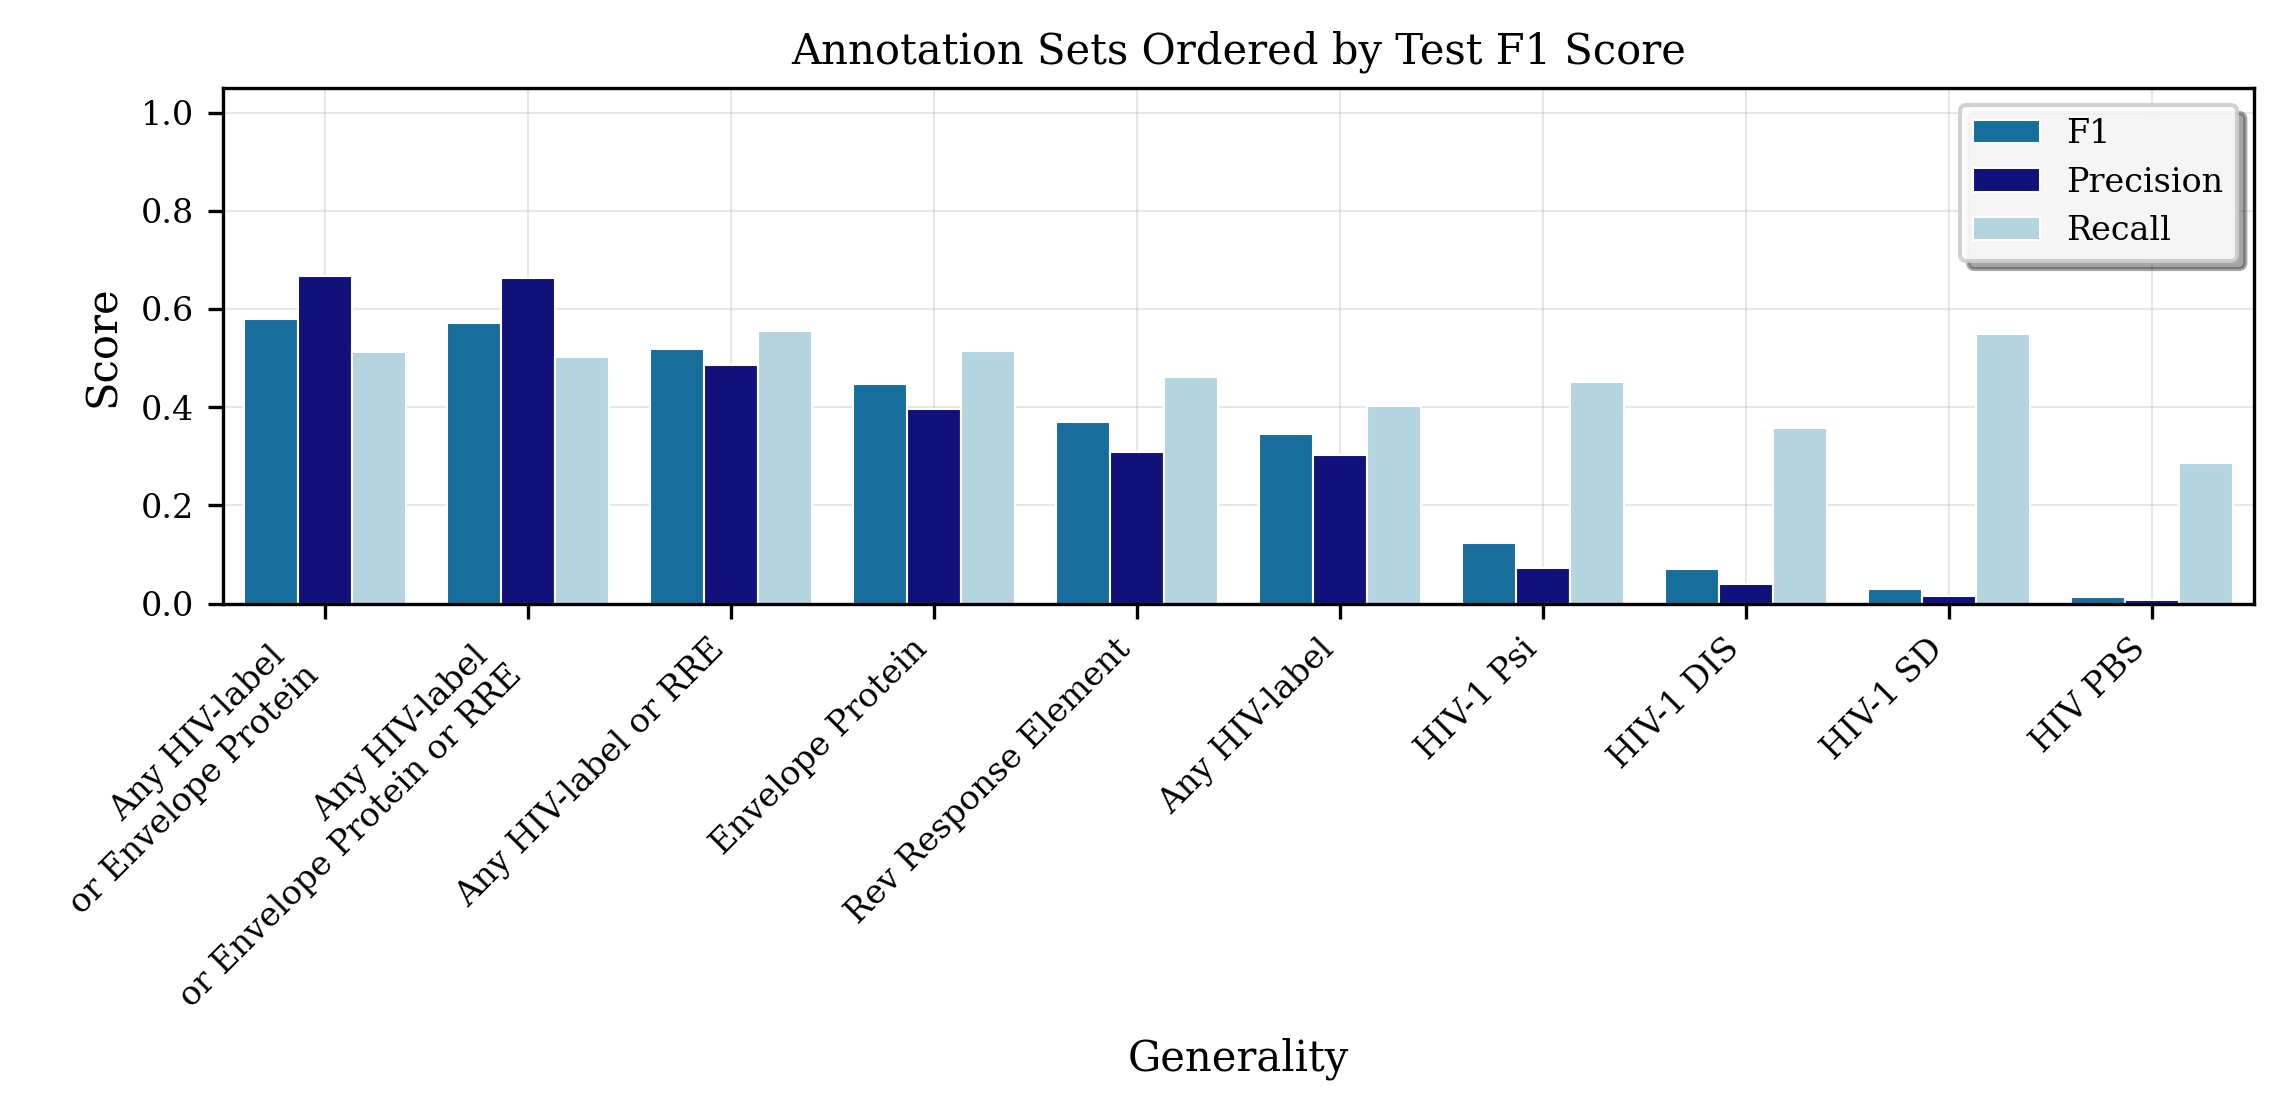

,annotation,test_f1,test_precision,test_recall
3,Any HIV-label \n or Envelope Protein,0.579580,0.667219,0.512291
6,Any HIV-label \n or Envelope Protein or RRE,0.572045,0.662946,0.503067
4,Any HIV-label or RRE,0.517611,0.484833,0.555143
1,Envelope Protein,0.448170,0.396708,0.514973
2,Rev Response Element,0.369638,0.308297,0.461451
0,Any HIV-label,0.345537,0.302539,0.402781
7,HIV-1 Psi,0.124031,0.071891,0.451467
9,HIV-1 DIS,0.070187,0.038920,0.356913
10,HIV-1 SD,0.029056,0.014923,0.549020
8,HIV PBS,0.013650,0.006991,0.287151


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Visualization setup ---
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.weight"] = "normal"
colors = sns.color_palette('colorblind')

# --- Prepare dataframe ---
df_results = df_results.sort_values("test_f1", ascending=False)

# --- Melt for seaborn plotting ---
plot_df = df_results.melt(
    id_vars="annotation",
    var_name="Metric",
    value_name="Score"
)

plot_df["Metric"] = plot_df["Metric"].replace({
    "test_f1": "F1",
    "test_precision": "Precision",
    "test_recall": "Recall"
})

metric_colors = {
    "F1": colors[0],             # colorblind-safe blue
    "Precision": "darkblue",
    "Recall": "lightblue"
}

# Ensure order by descending F1
annotation_order = df_results["annotation"].tolist()

# --- Plot ---
plt.figure(figsize=(7.75, 3.8), dpi=300)

sns.barplot(
    data=plot_df,
    x="annotation", y="Score", hue="Metric",
    order=annotation_order,
    palette=metric_colors,
    edgecolor="white", linewidth=0.5
)

# --- Aesthetics ---
plt.title("Annotation Sets Ordered by Test F1 Score", fontsize=10)
plt.xlabel("Generality", fontsize=10)
plt.ylabel("Score", fontsize=10)
plt.xticks(rotation=45, ha="right", fontsize=8)
plt.yticks(fontsize=8)
plt.ylim(0, 1.05)
plt.grid(True, alpha=0.3, linewidth=0.5)
plt.gca().set_axisbelow(True)

# --- Legend ---
legend = plt.legend(
    fontsize=8,
    frameon=True,
    fancybox=True,
    shadow=True,
    loc="upper right"
)
legend.get_frame().set_facecolor("white")
legend.get_frame().set_alpha(0.9)

plt.tight_layout()
plt.show()

# Optional: display sorted table for inspection
display(df_results)
